In [62]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

ModuleNotFoundError: No module named 'seaborn'

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Keyword and Location are the main missing features

### Modeling

In [8]:
X = df_train['text']
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 69)

In [5]:
y.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

#### Logreg 

In [44]:
logr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logr', LogisticRegression())
])

In [45]:
logr_params = {
        'tfidf__max_features': [2000,2500],
        'tfidf__min_df': [1,5,10],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__stop_words': ['english', None],
        'tfidf__ngram_range': [(1, 2)],
        'logr__C': [0.1, 1, 10],
        'logr__penalty': ['l2'], #
        'logr__solver': ['liblinear']
    }

In [46]:
gs_lr = GridSearchCV(logr, logr_params, cv=5, n_jobs=1)

In [47]:
gs_lr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=1,
             param_grid={'logr__C': [0.1, 1, 10], 'logr__penalty': ['l2'],
                         'logr__solver': ['liblinear'],
                         'tfidf': [TfidfVectorizer(max_df=0.9,
                                                   max_features=2500,
                                                   ngram_range=(1, 2),
                                                   stop_words='english')],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 2500],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': ['english', None]})

In [49]:
gs_lr.best_params_

{'logr__C': 1,
 'logr__penalty': 'l2',
 'logr__solver': 'liblinear',
 'tfidf': TfidfVectorizer(max_df=0.9, max_features=2500, ngram_range=(1, 2),
                 stop_words='english'),
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 2500,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': 'english'}

In [51]:
gs_lr.score(X_train,y_train), gs_lr.score(X_test,y_test)

(0.8584690839026099, 0.7899159663865546)

In [55]:
# Get predictions
preds = gs_lr.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

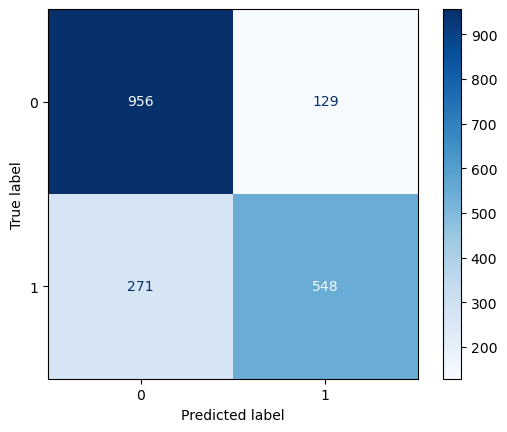

In [57]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_lr, X_test, y_test, cmap='Blues', values_format='d');

In [60]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_lr.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
421,0,0.258008
5047,0,0.671224
5046,0,0.385309
1881,0,0.175295
6543,0,0.210184


In [61]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.displot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
# Add cutoff line
plt.axvline(0.2, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

NameError: name 'sns' is not defined

<Figure size 1200x500 with 0 Axes>

#### MNB 

In [13]:
pipe =Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [14]:
pipe_params = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__stop_words': [None, 'english'],
    'mnb__alpha': [0.1, 0.5, 1.0],
}

In [15]:
gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=1 )

In [16]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'mnb__alpha': [0.1, 0.5, 1.0],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__max_features': [1000, 5000, 10000],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': [None, 'english']})

In [19]:
print("Best Parameters: ", gs.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(gs.best_score_))


Best Parameters:  {'mnb__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Best Cross-Validation Score: 0.80


In [21]:
gs.score(X_train,y_train)

0.8728323699421965

In [20]:
gs.score(X_test,y_test)

0.8009453781512605

#### Bigboyshit

In [54]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kalymaan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ModuleNotFoundError: No module named 'tensorflow'